In [27]:
# import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from itertools import chain
%matplotlib inline
df = pd.read_csv('../res/input0130.csv',index_col=0)
orig_df = pd.read_csv('../xau_1d_20y.csv')
orig_df['log_r'] = df['log_r']
orig_df['label'] = df['label']

In [34]:
orig_df['date'] = pd.to_datetime(orig_df['date'])
orig_df = orig_df.set_index('date')

In [74]:
orig_df.fillna(0).to_csv('../res/test_data.csv')

In [12]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import backtrader as bt

In [67]:
from backtrader.feeds import GenericCSVData
class MyData(GenericCSVData):
    lines = ('label',)
    params = (
        ('dtformat', ('%Y-%m-%d')),
        ('label', 6),
    )

In [71]:
class GoldStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.label = self.datas[0].label
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f, label %d' % (self.dataclose[0],self.label[0]))
        # self.log('Close, %.2f' % self.dataclose[0])
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            if self.label[0] == 1:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
            # # Not yet ... we MIGHT BUY if ...
            # if self.dataclose[0] < self.dataclose[-1]:
            #         # current close less than previous close

            #         if self.dataclose[-1] < self.dataclose[-2]:
            #             # previous close less than the previous close

            #             # BUY, BUY, BUY!!! (with default parameters)
            #             self.log('BUY CREATE, %.2f' % self.dataclose[0])

            #             # Keep track of the created order to avoid a 2nd order
            #             self.order = self.buy()

        else:

            # Already in the market ... we might sell
            # if len(self) >= (self.bar_executed + 5):
            if self.label[0] == 0:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [45]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

38.25
2018-12-05, SELL EXECUTED, 1238.70
2018-12-05, Close, 1236.88, label 1
2018-12-05, BUY CREATE, 1236.88
2018-12-06, BUY EXECUTED, 1236.80
2018-12-06, Close, 1237.50, label 1
2018-12-07, Close, 1248.19, label 0
2018-12-07, SELL CREATE, 1248.19
2018-12-10, SELL EXECUTED, 1249.29
2018-12-10, Close, 1244.20, label 0
2018-12-11, Close, 1242.80, label 1
2018-12-11, BUY CREATE, 1242.80
2018-12-12, BUY EXECUTED, 1242.82
2018-12-12, Close, 1245.34, label 0
2018-12-12, SELL CREATE, 1245.34
2018-12-13, SELL EXECUTED, 1245.57
2018-12-13, Close, 1241.71, label 0
2018-12-14, Close, 1238.54, label 1
2018-12-14, BUY CREATE, 1238.54
2018-12-17, BUY EXECUTED, 1238.46
2018-12-17, Close, 1245.56, label 1
2018-12-18, Close, 1249.19, label 0
2018-12-18, SELL CREATE, 1249.19
2018-12-19, SELL EXECUTED, 1249.64
2018-12-19, Close, 1242.69, label 1
2018-12-19, BUY CREATE, 1242.69
2018-12-20, BUY EXECUTED, 1242.77
2018-12-20, Close, 1259.69, label 0
2018-12-20, SELL CREATE, 1259.69
2018-12-21, SELL EXECUTED,

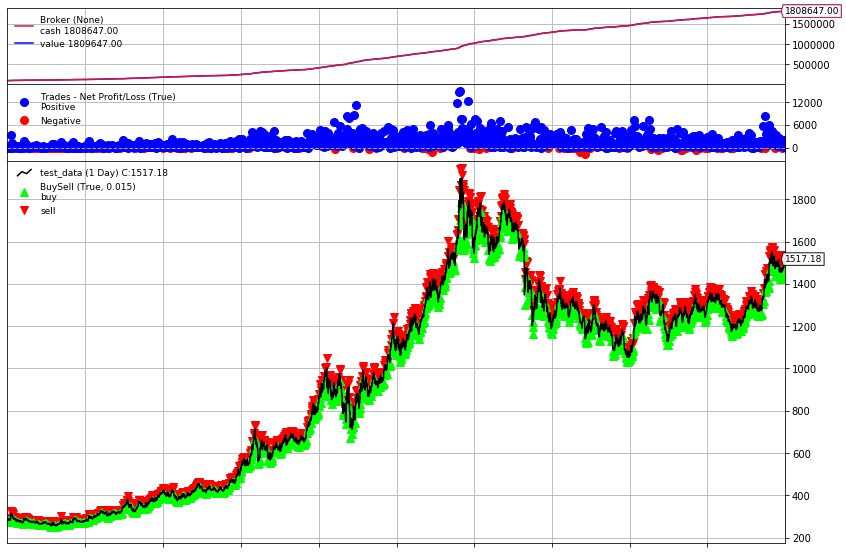

[[<Figure size 864x576 with 3 Axes>]]

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12,8
cerebro = bt.Cerebro()
data = MyData(dataname='../res/test_data.csv')
cerebro.adddata(data)
cerebro.addstrategy(GoldStrategy)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=50,margin=1000,mult=100)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot(iplot=False,volume=False)

In [24]:
cerebro.datas[0]

In [19]:
cerebro.adddata(data)